In [75]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bars(df, lst_features, lst_split = ['Transported'], ylim=(0,1)):
    """ Вывод значений для прихнаков из списка lst_features. Вычисление для них доли признкака lst_split """
    cols, i = len(lst_features)*len(lst_split), 1
    plt.figure(figsize=(cols*5, 4), facecolor ='w')     
    for f in lst_features: 
        for split in lst_split:         
            x = np.array( list(dict(df[f].value_counts()).items() ))            
            ax1 = plt.subplot(1, cols, i)
            plt.ylim(0, len(df)); plt.title(f); plt.yticks([]); # plt.xticks(x[:,0])
            plt.bar(x[:,0], x[:,1].astype(int))
            
            s = [  df.loc[df[f] == k, split].mean() for k, _ in x ]
            ax2 = ax1.twinx(); ax2.set_ylim(ylim)
            plt.plot(x[:,0], s, ":og", markersize=8)
            plt.axhline(y = (ylim[0]+ylim[1])/2, color = 'gray', linestyle = '-')
            plt.yticks(np.linspace(ylim[0],ylim[1],11)); plt.legend([split])
            plt.grid()
            i += 1
    plt.show()    

df = pd.read_csv("dataset/train.csv")
df = df[(df.Name.notna()) ] # & (df.CryoSleep == False)
print(df.shape)
df = df[['Name', 'CryoSleep', 'Transported']]
df['Name1'] = df.Name.map(lambda x: x.split(" ")[0])
display(df)
df.Name1.value_counts()

(8493, 14)


,Name,CryoSleep,Transported,Name1
0,Maham Ofracculy,False,False,Maham
1,Juanna Vines,False,True,Juanna
2,Altark Susent,False,False,Altark
3,Solam Susent,False,False,Solam
4,Willy Santantines,False,True,Willy
...,...,...,...,...
8688,Gravior Noxnuther,False,False,Gravior
8689,Kurta Mondalley,True,False,Kurta
8690,Fayey Connon,False,True,Fayey
8691,Celeon Hontichre,False,False,Celeon


Idace      13
Loree      12
Glena      11
Gwendy     11
Kaye       11
           ..
Capies      1
Blues       1
Preonon     1
Siese       1
Chain       1
Name: Name1, Length: 2706, dtype: int64

In [76]:
print(f"{df.Transported.mean():.3f}    {df.CryoSleep.mean():.3f}")
for i, (n,c) in enumerate(dict(df.Name1.value_counts()).items()):
    print(f"{n:10s}  {c:2d} {df[df.Name1 == n].Transported.mean():.3f}  {df[df.Name1 == n].CryoSleep.mean():.3f}")
    if i > 10: break

0.504    0.359
Idace       13 0.154  0.231
Loree       12 0.583  0.250
Glena       11 0.545  0.455
Gwendy      11 0.364  0.182
Kaye        11 0.545  0.545
Dandra      11 0.364  0.182
Jerrye      10 0.300  0.300
Eriky       10 0.300  0.333
Benny       10 0.200  0.444
Eulah       10 0.400  0.200
Jorgie      10 0.600  0.400
Patoya      10 0.200  0.333


In [90]:
class WordTree:
    """ list :- [n,t,dict], dict :- {ch: list,...}   example:   [10, 5, { 'a': [8,3, {} ] ,...   }] """
    def __init__(self, inverse = True):
        self.inverse = inverse
        self.root = [0, 0, {}]
        self.depth = 0
        
    def add(self, word, label):
        self.depth = max(self.depth, len(word)+1)
        self.root[0] += 1
        self.root[1] += label
        
        if self.inverse:
            word = word[::-1]
        word += "#"
        
        node = self.root[2]
        for ch in word:
            if ch in node:
                lst = node[ch]
                lst[0] += 1
                lst[1] += label
                node = lst[2]
            else:
                node[ch] = [1, label, {}]
                node = node[ch][2]
    
    def predict(self, word, max_depth = 100):
        if self.inverse:
            word = word[::-1]
        word += "#"            
        word = word[:max_depth]
        
        node = self.root
        for ch in word:            
            if ch in node[2]:
                node = node[2][ch]                
            else:                
                return node[0], node[1], 0
                               
        return node[0], node[1], 1
    
    def score(self, word, max_depth = 100):
        n,k,ok = self.predict(word, max_depth)
        return k/n
    
    def info(self):
        print(f"num:{self.root[0]}, labels:{self.root[1]}, depth:{self.depth}")
    
    def show(self, level = 0):
        print(f"({self.root[0]},{self.root[1]})")
        self.show_rec(self.root[2], 0)
        
    def show_rec(self, node, level):        
        skip = " "*(4*level)          
        for k in node:
            print(f"{skip} {k}  ({node[k][0]},{node[k][1]})")
            self.show_rec(node[k][2], level+1)
        
        
wt = WordTree()

wt.add("маша",  1)
wt.add("саша",  0)
wt.add("саша",  1)
wt.add("коля",  0)
wt.add("оля",   1)
wt.add("поля",  1)

#wt.show()
wt.info()
print(wt.predict("саша", 2))
print(wt.score("саша"))

num:6, labels:4, depth:5
(3, 2, 1)
0.5


In [93]:
wt = WordTree()
for i in range(len(df)):
    wt.add(df.iloc[i].Name1, int(df.iloc[i].Transported))
wt.info()

df['sex'] = df.Name1.map(lambda x: wt.score(x, 3) )

num:8493, labels:4277, depth:8


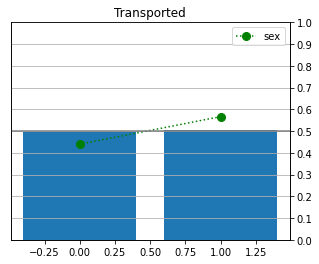

In [94]:
plot_bars  (df, ['Transported'], ['sex'])

In [ ]:
def set_sex(df_trn, df_tst):
    wt = WordTree()
    
    for i in range(len(df_trn)):
        wt.add(df_trn.iloc[i].Name1, int(df_trn.iloc[i].Transported))    
        
    df_trn['Sex'] = df_trn.Name1.map(lambda x: wt.score(x, 4) )
    df_tst['Sex'] = df_tst.Name1.map(lambda x: wt.score(x, 4) )